In [5]:
from mm_ab import *

In [6]:
sql_data = pd.read_pickle('../data/expN34.pkl')

In [7]:
test_of_tests = {}
effect_size = {}

# База
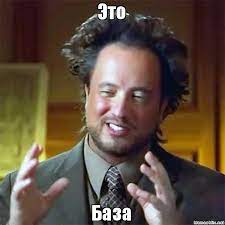

In [8]:
qq = sql_data.copy()

In [9]:
qq.pivot('user',['part','ab'],['view','click'])

view                  click               
part                    AB   AA    AB    AA    AB   AA   AB   AA
ab                       0    0     1     1     0    0    1    1
user                                                            
1000001426235542855    NaN  NaN   3.0   NaN   NaN  NaN  0.0  NaN
10000041164695327753   NaN  NaN   1.0   NaN   NaN  NaN  0.0  NaN
10000437167754453419   NaN  NaN  25.0  14.0   NaN  NaN  5.0  0.0
100006266691692773     2.0  NaN   NaN   NaN   0.0  NaN  NaN  NaN
10000729822855793980   NaN  NaN   NaN   4.0   NaN  NaN  NaN  0.0
...                    ...  ...   ...   ...   ...  ...  ...  ...
9999466463717575277    7.0  4.0   NaN   NaN   0.0  0.0  NaN  NaN
9999470750505133276    2.0  7.0   NaN   NaN   0.0  1.0  NaN  NaN
9999529376394046543   13.0  NaN   NaN   NaN   0.0  NaN  NaN  NaN
9999836269161512864    6.0  3.0   NaN   NaN   0.0  0.0  NaN  NaN
9999963259659259277    4.0  2.0   NaN   NaN   0.0  0.0  NaN  NaN

[134541 rows x 8 columns]

In [10]:
hahaha_ab_df = qq.pivot('user',['part','ab'],['view','click'])
hahaha_test = hahaha_ab_df['click'] / hahaha_ab_df['view']

In [11]:
test_of_tests['hahahah'] = {
                            'AA':sps.ttest_ind(hahaha_test['AA'][0].dropna(),hahaha_test['AA'][1].dropna()).pvalue,
                            'AB':sps.ttest_ind(hahaha_test['AB'][0].dropna(),hahaha_test['AB'][1].dropna()).pvalue,
                            }

In [12]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.64553,0.18029


In [13]:
effect_size['hahahah'] = hahaha_test.mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

In [14]:
test_of_tests['hahahah_log'] = {
                            'AA':sps.ttest_ind(hahaha_test['AA'][0].dropna().apply(np.log1p),hahaha_test['AA'][1].dropna().apply(np.log1p)).pvalue,
                            'AB':sps.ttest_ind(hahaha_test['AB'][0].dropna().apply(np.log1p),hahaha_test['AB'][1].dropna().apply(np.log1p)).pvalue,
                            }

In [15]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682


In [16]:
effect_size['hahahah_log'] = hahaha_test.apply(np.log1p).mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

# Настоящая база
<img src='https://www.meme-arsenal.com/memes/28beaa87227d46e0d91f2f3cb697f89c.jpg' width=400 height=400/>

In [17]:
# А настоящая база, когда мы проверили наш сет на предмет возможного пиздеца

In [18]:
# мммммммммммммммммммммммммммммммммммммммммммммм 1053 платежки за 2 недели ммммммммммммммммммммммммммммммм
sql_data[['view','click']].describe()

,view,click
count,181525.000000,181525.000000
mean,4.207757,0.323217
std,6.904729,1.041286
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,0.000000
max,1055.000000,49.000000


In [19]:
# Убираем аккуратно, нужно брать бейзлайн именно с АА теста, чтобы в АБ у нас был унифицированная граница отрубания
views_aa_quantile = sql_data.query('part=="AA"')['view'].quantile(.99)
base = sql_data.copy().where(lambda x: x['view']<views_aa_quantile).dropna()

In [20]:
# Отдельно взятые средне не сместились, а вот разброс ушел - Мы молодцы!
base[['view','click']].describe()

,view,click
count,179537.000000,179537.000000
mean,3.734239,0.317834
std,3.873744,0.972961
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,0.000000
max,29.000000,23.000000


In [21]:
base_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])
base_test = base_test['click'] / base_test['view']

In [22]:
# CTR 200% mmmmmmmmmmmmmmm
base_test.describe()

part,AB,AA,AB,AA
ab,1.0,1.0,0.0,0.0
count,41079.000000,48537.000000,41229.000000,48692.000000
mean,0.081543,0.079013,0.079465,0.078322
std,0.217543,0.216069,0.216574,0.214190
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,2.000000,3.000000,2.000000,3.000000


In [23]:
base_test.where(lambda x: x<=1).dropna(thresh=1)

part,AB,AA,AB,AA
ab,1.0,1.0,0.0,0.0
user,,,,
1000001426235542855,0.0,NaN,NaN,NaN
10000041164695327753,0.0,NaN,NaN,NaN
10000437167754453419,0.2,0.0,NaN,NaN
100006266691692773,NaN,NaN,0.0,NaN
10000729822855793980,NaN,0.0,NaN,NaN
...,...,...,...,...
9999466463717575277,NaN,NaN,0.0,0.000000
9999470750505133276,NaN,NaN,0.0,0.142857


In [24]:
# Убираем наших уберкликеров
base_test = base_test.where(lambda x: x<=1).dropna(thresh=1)

In [25]:
base_test.describe()

part,AB,AA,AB,AA
ab,1.0,1.0,0.0,0.0
count,41060.000000,48479.000000,41211.000000,48634.000000
mean,0.080782,0.076894,0.078699,0.076247
std,0.214613,0.206963,0.213420,0.205294
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [26]:
test_of_tests['base'] = {
                            'AA':sps.ttest_ind(base_test['AA'][0].dropna(),base_test['AA'][1].dropna()).pvalue,
                            'AB':sps.ttest_ind(base_test['AB'][0].dropna(),base_test['AB'][1].dropna()).pvalue,
                            }

In [27]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786


In [28]:
effect_size['base'] = base_test.mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

In [29]:
test_of_tests['base_log'] = {
                            'AA':sps.ttest_ind(base_test['AA'][0].dropna().apply(np.log1p),base_test['AA'][1].dropna().apply(np.log1p)).pvalue,
                            'AB':sps.ttest_ind(base_test['AB'][0].dropna().apply(np.log1p),base_test['AB'][1].dropna().apply(np.log1p)).pvalue,
                            }
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914


In [30]:
effect_size['base_log'] = base_test.apply(np.log1p).mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

# Наш выбор если CTR (Linearization)
* Оч просто
* Но не понято

<img src='https://icdn.lenta.ru/images/2017/10/02/18/20171002185339048/original_d914c38487d8383acb871620d1d3eef3.jpg' width=400 height=400/>

In [31]:
# берем CTR контроля и считаем новую метрику, как разницу скликов и произведения просмотров на наш CTR контроля.
# По итогу получаем в обоих случаях среднее контрольной группы 0, а тритмента в размере нашего аплифта


In [32]:
linear_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [33]:
k = linear_test['click'].sum().div(linear_test['view'].sum()).unstack()[0].rename('k')

In [34]:
k

part
AA    0.087475
AB    0.079888
Name: k, dtype: float64

In [35]:
linear_test = linear_test['click'] - linear_test['view'].apply(lambda x: x * k[x.name[0]])

In [36]:
test_of_tests['linear'] = {
                            'AA':sps.ttest_ind(linear_test['AA'][0].dropna(),linear_test['AA'][1].dropna()).pvalue,
                            'AB':sps.ttest_ind(linear_test['AB'][0].dropna(),linear_test['AB'][1].dropna()).pvalue,
                            }

In [37]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530


In [38]:
effect_size['linear'] = linear_test.mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

# Наш выбор если CTR Flex
* Оч просто
* Чуть понятнее

<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTpmP9dQlzF3siuqQNZhn042VnKknN10ZDa7Q&usqp=CAU' width=400 height=400/>

In [39]:
bayesian_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2]).sum()


In [40]:
AA_control = sps.beta(*bayesian_test.swaplevel(0,2)[0]['AA'][['click','view']].values).rvs(10000)
AA_threatment = sps.beta(*bayesian_test.swaplevel(0,2)[1]['AA'][['click','view']].values).rvs(10000)
AB_control = sps.beta(*bayesian_test.swaplevel(0,2)[0]['AB'][['click','view']].values).rvs(10000)
AB_threatment = sps.beta(*bayesian_test.swaplevel(0,2)[1]['AB'][['click','view']].values).rvs(10000)

Text(0.5, 1.0, 'AA test')

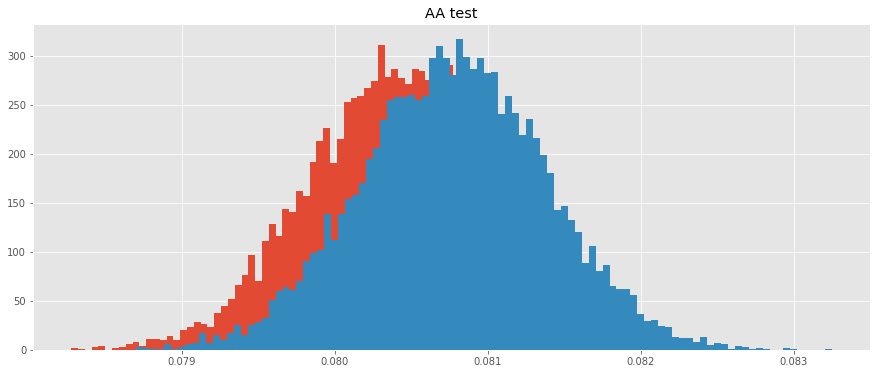

In [41]:
plt.hist(AA_control,bins=100);
plt.hist(AA_threatment,bins=100);
plt.title('AA test')

Text(0.5, 1.0, 'AB test')

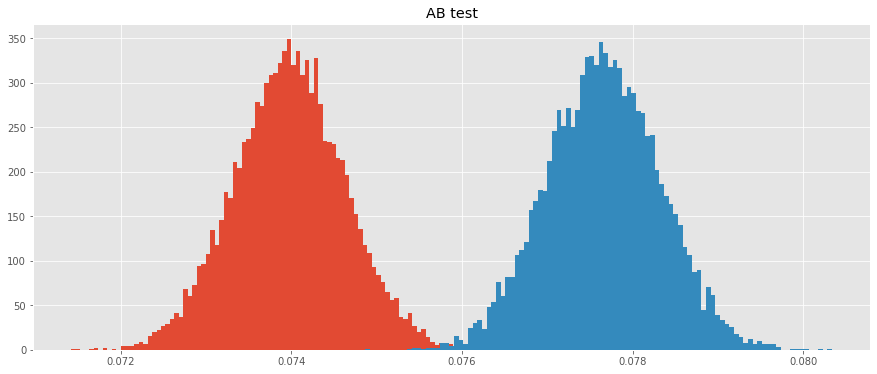

In [42]:
plt.hist(AB_control,bins=100);
plt.hist(AB_threatment,bins=100);
plt.title('AB test')

In [43]:
# А как формализовать? 

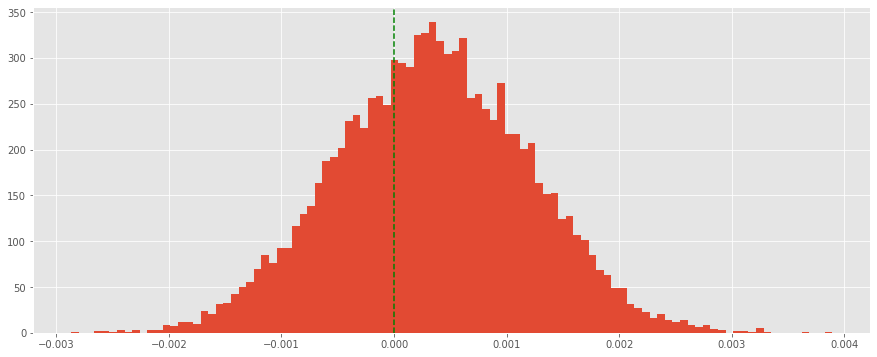

In [44]:
# Посмотрим разницу
plt.hist(AA_threatment - AA_control,bins=100);
plt.axvline(0,linestyle='--',color='g')

Text(0.5, 1.0, 'Вероятность того, что вариант Б лучше 65.46%')

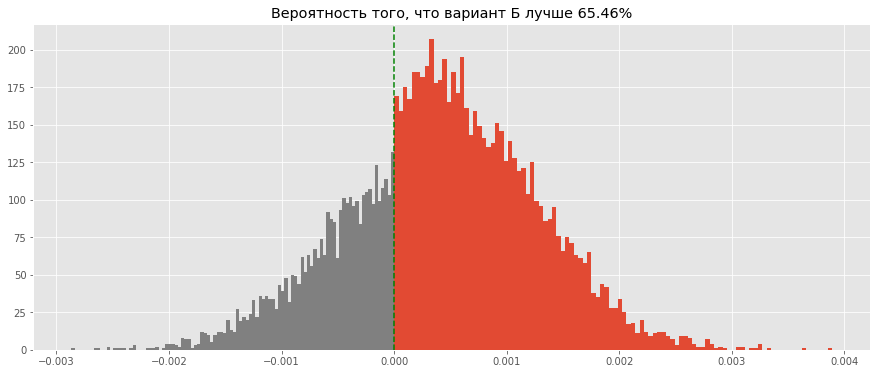

In [45]:
# А теперь посчитаем сколько в скольких случаев тритмент лучше нашего контроля
# Серая область это когда лучше контроль, красная, когда лучше тритмент
# И теперь оцениваем объем и сравниваем
plt.hist((AA_threatment - AA_control)[(AA_threatment - AA_control)<0],bins=100,color='grey');
plt.hist((AA_threatment - AA_control)[(AA_threatment - AA_control)>0],bins=100);
plt.axvline(0,linestyle='--',color='g')
plt.title(f'Вероятность того, что вариант Б лучше {(AA_threatment > AA_control).mean():.2%}')

Text(0.5, 1.0, 'Вероятность того, что вариант Б лучше 100.00%')

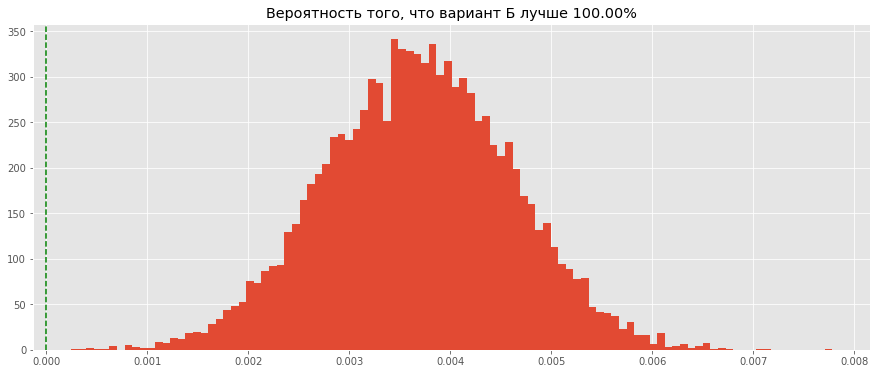

In [46]:
# Посмотрим разницу
plt.hist(AB_threatment - AB_control,bins=100);
plt.axvline(0,linestyle='--',color='g')
plt.title(f'Вероятность того, что вариант Б лучше {(AB_threatment > AB_control).mean():.2%}')

Text(0.5, 1.0, 'Uplift от наших улучшений 4.73%')

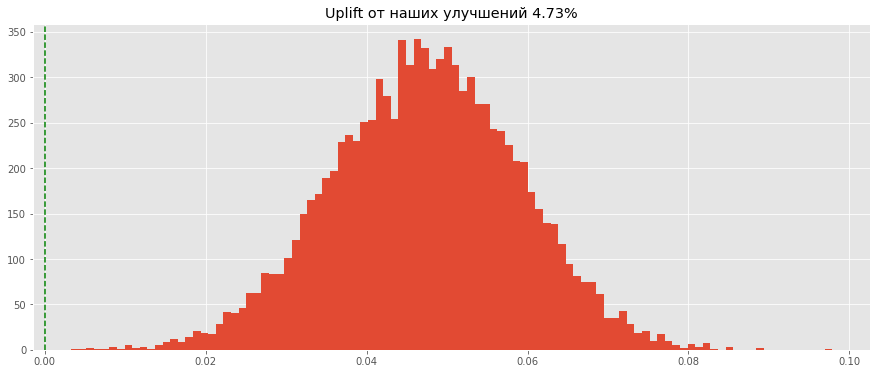

In [47]:
# Посмотрим разницу
plt.hist((AB_threatment - AB_control) / AB_threatment,bins=100);
plt.axvline(0,linestyle='--',color='g')
plt.title(f'Uplift от наших улучшений {((AB_threatment - AB_control) / AB_threatment).mean():.2%}')

In [48]:
test_of_tests['bayesian'] = {
                            'AA':min((AA_threatment > AA_control).mean(),1 - (AA_threatment > AA_control).mean()) * 2,
                            'AB':min((AB_threatment > AB_control).mean(),1 - (AB_threatment > AB_control).mean()) * 2,
                            }

In [49]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530
bayesian,0.690800,0.000000


In [50]:
effect_size ['bayesian'] = {'AA':AA_threatment.mean() - AA_control.mean(),
                            'AB':AB_threatment.mean() - AB_control.mean()}

# Наш выбор если CTR + важна активность (Перевзвешивание)
* Сложновато
* Зато понятно почему

<img src='http://images2.memedroid.com/images/UPLOADED37/5160beb129d16.jpeg' width=400 height=400/>

In [51]:
reweight_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [52]:
weight_coef = np.sqrt(reweight_test['view'])

In [53]:
# average CTR
avg_ctr = (reweight_test['click'] / reweight_test['view']).mean().unstack()
avg_ctr

ab,0.0,1.0
part,,
AA,0.078322,0.079013
AB,0.079465,0.081543


In [54]:
# Global CTR
global_ctr = (reweight_test['click'].sum() / reweight_test['view'].sum()).unstack()
global_ctr

ab,0.0,1.0
part,,
AA,0.087475,0.087872
AB,0.079888,0.084196


In [55]:
# С нелинейным учетом веса
reweight_ctr = reweight_test['click'].div(reweight_test['view']).mul(weight_coef).div(weight_coef.mean()).mean().unstack()
reweight_ctr

ab,0.0,1.0
part,,
AA,0.085383,0.085793
AB,0.082261,0.085341


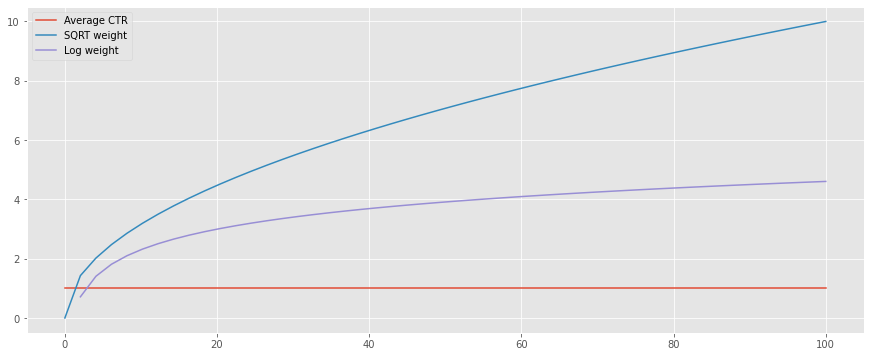

In [56]:
# Различные веса
# plt.plot(np.linspace(0,100),np.linspace(0,100))
plt.plot(np.linspace(0,100),np.ones(50))
plt.plot(np.linspace(0,100),np.linspace(0,100)**.5)
plt.plot(np.linspace(0,100),np.log(np.linspace(0,100)))
plt.legend(['Average CTR','SQRT weight','Log weight'])

In [57]:
alpha = 1
kw = reweight_test['click'].sum().div(reweight_test['view'].sum()) * alpha
reweight_test['click'].add( kw).div(reweight_test['view'].add( alpha)).mean().unstack()

ab,0.0,1.0
part,,
AA,0.084824,0.085256
AB,0.081980,0.085075


In [58]:
alpha_df = []
for alpha in np.linspace(0,1):
    kw = reweight_test['click'].sum().div(reweight_test['view'].sum()) * alpha
    alpha_df.append(reweight_test['click'].add( kw).div(reweight_test['view'].add( alpha)).mean().rename(alpha))
alpha_df = pd.concat(alpha_df,axis=1)

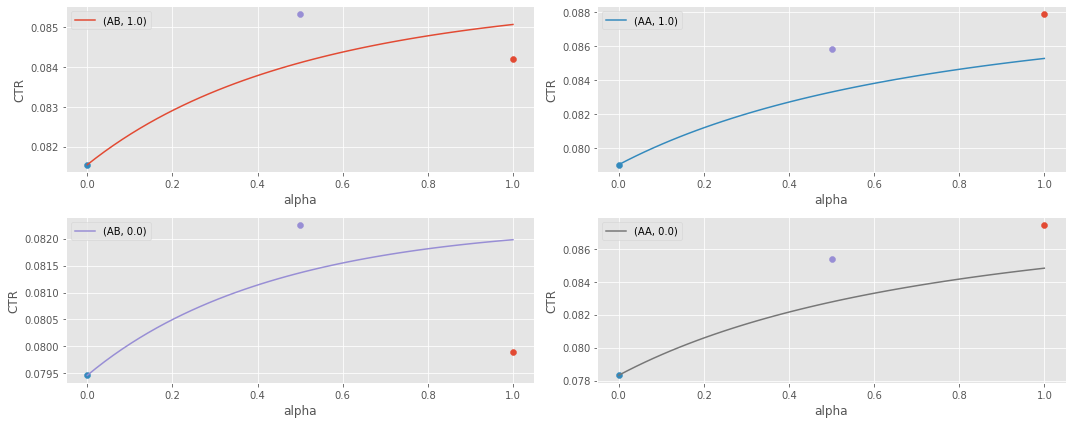

In [59]:
fig,ax = plt.subplots(2,2)
alpha_df.T.plot(subplots=True,ax=ax,xlabel='alpha',ylabel='CTR')
ax[0,0].scatter(x=1,y=global_ctr.loc['AB',1])
ax[0,0].scatter(x=0,y=avg_ctr.loc['AB',1])
ax[0,0].scatter(x=.5,y=reweight_ctr.loc['AB',1])


ax[0,1].scatter(x=1,y=global_ctr.loc['AA',1])
ax[0,1].scatter(x=0,y=avg_ctr.loc['AA',1])
ax[0,1].scatter(x=.5,y=reweight_ctr.loc['AA',1])

ax[1,0].scatter(x=1,y=global_ctr.loc['AB',0])
ax[1,0].scatter(x=0,y=avg_ctr.loc['AB',0])
ax[1,0].scatter(x=.5,y=reweight_ctr.loc['AB',0])

ax[1,1].scatter(x=1,y=global_ctr.loc['AA',0])
ax[1,1].scatter(x=0,y=avg_ctr.loc['AA',0])
ax[1,1].scatter(x=.5,y=reweight_ctr.loc['AA',0])
plt.tight_layout()

In [60]:
reweight_test_df = reweight_test['click'].add( kw).div(reweight_test['view'].add( alpha))

In [61]:
test_of_tests['reweight_ctr_coef'] = {
                            'AA':sps.ttest_ind(reweight_test_df['AA'][0].dropna(),reweight_test_df['AA'][1].dropna()).pvalue,
                            'AB':sps.ttest_ind(reweight_test_df['AB'][0].dropna(),reweight_test_df['AB'][1].dropna()).pvalue,
                            }

In [62]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530
bayesian,0.690800,0.000000
reweight_ctr_coef,0.656736,0.003065


In [63]:
effect_size['reweight_ctr_coef'] = reweight_test_df.mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

In [64]:
reweight_test_df = reweight_test['click'].div(reweight_test['view']).mul(weight_coef).div(weight_coef.mean())

In [65]:
test_of_tests['reweight_ctr'] = {
                            'AA':sps.ttest_ind(reweight_test_df['AA'][0].dropna(),reweight_test_df['AA'][1].dropna()).pvalue,
                            'AB':sps.ttest_ind(reweight_test_df['AB'][0].dropna(),reweight_test_df['AB'][1].dropna()).pvalue,
                            }

In [66]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530
bayesian,0.690800,0.000000
reweight_ctr_coef,0.656736,0.003065
reweight_ctr,0.779160,0.045775


In [67]:
effect_size['reweight_ctr_log'] = reweight_test_df.mean().unstack().apply(lambda x: x[1] - x[0],axis=1).to_dict()

# В любой непонятной ситуации (Bucketing)
<img src='https://i.pinimg.com/736x/7a/97/bd/7a97bd9304643c2d27fb6ef2dbb0cf07.jpg'>

In [68]:
bucket_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [69]:
bucket_size = 100
n_buckets = bucket_test['view'].count().min() // bucket_size

In [70]:
bucket_df = {}
part_ab = bucket_test.swaplevel(0,2,axis=1).droplevel(2,axis=1).columns.unique()
for exp in part_ab:

    tmp = []

    for bucket in tqdm(range(n_buckets)):

        meta_user = bucket_test.swaplevel(0,2,axis=1).loc[:,exp].iloc[bucket * bucket_size: (bucket+1) * bucket_size].sum()
        
        ctr_meta_user = meta_user['click'] / meta_user['view']
        tmp.append(ctr_meta_user)

    bucket_df.update({exp:tmp})
bucket_df = pd.DataFrame(bucket_df)

100%|██████████| 410/410 [00:01<00:00, 232.52it/s]


array([[<AxesSubplot:title={'center':"(1.0, 'AB')"}>,
        <AxesSubplot:title={'center':"(1.0, 'AA')"}>],
       [<AxesSubplot:title={'center':"(0.0, 'AB')"}>,
        <AxesSubplot:title={'center':"(0.0, 'AA')"}>]], dtype=object)

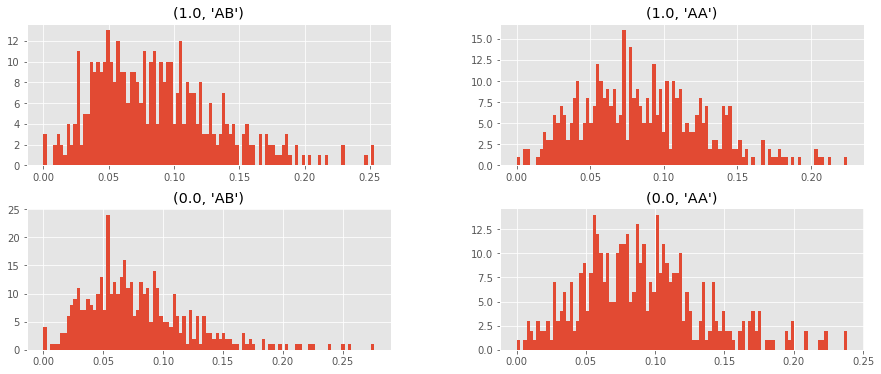

In [71]:
bucket_df.hist(bins=100)

In [72]:
test_of_tests['bucketing'] = {
                                'AA':sps.ttest_ind(pd.DataFrame(bucket_df).loc[:,(1,'AA')].dropna(),pd.DataFrame(bucket_df).loc[:,(0,'AA')].dropna()).pvalue,
                                'AB':sps.ttest_ind(pd.DataFrame(bucket_df).loc[:,(1,'AB')].dropna(),pd.DataFrame(bucket_df).loc[:,(0,'AB')].dropna()).pvalue,
                                }

In [73]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530
bayesian,0.690800,0.000000
reweight_ctr_coef,0.656736,0.003065
reweight_ctr,0.779160,0.045775
bucketing,0.140327,0.032743


In [74]:
effect_size['bucketing'] = bucket_df.mean().unstack().apply(lambda x: x[1] - x[0]).to_dict()

# В любой непонятной ситуации v2 ~~может не влезть по памяти~~ (Bootstrap)
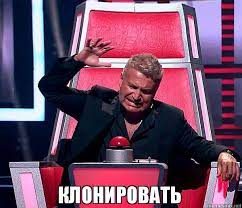

In [75]:
bootstrap_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [76]:
bootstrap_test_ctr = bootstrap_test['click'] / bootstrap_test['view']

In [77]:

min_size = bootstrap_test_ctr.count().min()
rr = np.random.default_rng(11)
bts_aa = []
bts_ab = []
for _ in tqdm(range(1000)):

    aa_c = rr.choice(bootstrap_test['click']['AA'][0].dropna().values,size=min_size,replace=True).sum() / rr.choice(bootstrap_test['view']['AA'][0].dropna().values,size=min_size,replace=True).sum()
    aa_t = rr.choice(bootstrap_test['click']['AA'][1].dropna().values,size=min_size,replace=True).sum() / rr.choice(bootstrap_test['view']['AA'][1].dropna().values,size=min_size,replace=True).sum()
    bts_aa.append(aa_t - aa_c)

    ab_c = rr.choice(bootstrap_test['click']['AB'][0].dropna().values,size=min_size,replace=True).sum() / rr.choice(bootstrap_test['view']['AB'][0].dropna().values,size=min_size,replace=True).sum()
    ab_t = rr.choice(bootstrap_test['click']['AB'][1].dropna().values,size=min_size,replace=True).sum() / rr.choice(bootstrap_test['view']['AB'][1].dropna().values,size=min_size,replace=True).sum()
    bts_ab.append(ab_t - ab_c)
bts_aa = np.array(bts_aa)
bts_ab = np.array(bts_ab)

100%|██████████| 1000/1000 [00:36<00:00, 27.35it/s]


In [78]:
test_of_tests['bootstrap'] = {
                                'AA':min((bts_aa <0).sum(),len(bts_aa) - (bts_aa <0).sum()) / len(bts_aa),
                                'AB':min((bts_ab <0).sum(),len(bts_ab) - (bts_ab <0).sum()) / len(bts_ab),
                                }

In [79]:
pd.DataFrame(test_of_tests).T

,AA,AB
hahahah,0.645530,0.180290
hahahah_log,0.702553,0.124682
base,0.624902,0.162786
base_log,0.679356,0.115914
linear,0.811256,0.012530
bayesian,0.690800,0.000000
reweight_ctr_coef,0.656736,0.003065
reweight_ctr,0.779160,0.045775
bucketing,0.140327,0.032743
bootstrap,0.409000,0.010000


In [80]:
effect_size['bootstrap'] = {'AA':bts_aa.mean(),
                            'AB':bts_ab.mean()}

# Combo Breaker
<img src = 'https://y.yarn.co/2c879f9a-f5b7-4eb8-8791-6328d8a2c877_screenshot.jpg'>

In [81]:
combo_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [82]:
AA_combo_df = generate_tests(*combo_test.swaplevel(0,2,axis=1)[0]['AA'].dropna().T.values,
                            *combo_test.swaplevel(0,2,axis=1)[1]['AA'].dropna().T.values)

In [83]:
AB_combo_df = generate_tests(*combo_test.swaplevel(0,2,axis=1)[0]['AB'].dropna().T.values,
                            *combo_test.swaplevel(0,2,axis=1)[1]['AB'].dropna().T.values)

In [84]:
AB_combo_df.T.sort_values(by='ci_lenght')

,ttest,mwtest,uplift,relative_uplift,ci_left,ci_right,ci_lenght,ci_left_lenght
Combo,0.000058,NaN,0.003679,0.049733,0.001878,0.005453,0.003575,0.000201
bayesian,0.000060,NaN,0.003679,0.049733,0.001884,0.005481,0.003597,NaN
base,0.169505,0.052352,0.002079,0.026160,-0.000887,0.005044,0.005931,NaN
ML,0.169510,NaN,0.002079,0.026160,-0.000887,0.005045,0.005932,NaN
reweight,0.044465,0.048607,0.003098,0.037673,0.000077,0.006120,0.006043,NaN
bootstrap,0.018000,NaN,0.004101,0.051268,0.000747,0.007457,0.006710,NaN
bucketing,0.014046,0.010675,0.004261,0.053132,0.000861,0.007661,0.006801,NaN
linearization,0.012534,0.150574,0.015909,NaN,0.003420,0.028398,0.024978,NaN


In [85]:
AB_combo_df.T.assign(left_lenght = 0.002654 - AB_combo_df.T['ci_left'])

,ttest,mwtest,uplift,relative_uplift,ci_left,ci_right,ci_lenght,ci_left_lenght,left_lenght
base,0.169505,0.052352,0.002079,0.026160,-0.000887,0.005044,0.005931,NaN,0.003541
reweight,0.044465,0.048607,0.003098,0.037673,0.000077,0.006120,0.006043,NaN,0.002577
linearization,0.012534,0.150574,0.015909,NaN,0.003420,0.028398,0.024978,NaN,-0.000766
bucketing,0.014046,0.010675,0.004261,0.053132,0.000861,0.007661,0.006801,NaN,0.001793
bootstrap,0.018000,NaN,0.004101,0.051268,0.000747,0.007457,0.006710,NaN,0.001907
bayesian,0.000060,NaN,0.003679,0.049733,0.001884,0.005481,0.003597,NaN,0.000770
ML,0.169510,NaN,0.002079,0.026160,-0.000887,0.005045,0.005932,NaN,0.003541
Combo,0.000058,NaN,0.003679,0.049733,0.001878,0.005453,0.003575,0.000201,0.000776


# ML
<img src = 'https://miro.medium.com/max/500/1*qHbAsMNmdWQJkzm2SUA-8w.jpeg'>

In [86]:
simple_ml_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [87]:
simple_ml_test_ctr = simple_ml_test['click'] / simple_ml_test['view']

In [88]:
ml_df = pd.concat([simple_ml_test_ctr.swaplevel(0,1,axis=1)[0].dropna(subset=['AB']),simple_ml_test_ctr.swaplevel(0,1,axis=1)[1].dropna(subset=['AB'])])

In [89]:
import statsmodels.api as sm

In [90]:
mldf = pd.get_dummies(sql_data.set_index(['user','part']).drop(['click','view'],axis=1)).join(ml_df.stack().rename('target')).swaplevel(0,1).fillna(0)

In [91]:
mldf_cup = mldf.join(mldf.loc['AA']['target'].rename('preexp_target')).fillna(0)

In [92]:
cuped_df = mldf.loc['AB'].join(mldf.loc['AA']['target'].rename('preexp_target')).loc[:,['ab','target','preexp_target']].dropna()

In [93]:
class ABML(BaseABMethod):

    def prepare_data(self,cov_dict=None):
        self.calc_metric()
        if cov_dict is None:
            cov_dict = {'control':np.array([]),
                        'threatment':np.array([])}
                        
        control_data = np.vstack([  
                                    np.zeros(self.control_views.shape[0]),
                                    *cov_dict['control'].T,
                                    np.ones(self.control_views.shape[0]),
                                    self.control_ctr])
        
        threatment_data = np.vstack([
                                    np.ones(self.threatment_views.shape[0]),
                                    *cov_dict['threatment'].T,
                                    np.ones(self.threatment_views.shape[0]),
                                    self.threatment_ctr])

        data = np.hstack([control_data,threatment_data]).T
        
        target = data[:,-1]
        data = data[:,:-1]

        return data,target


    def ci_check(self,raw=False,**kwargs):
        data,target = self.prepare_data(**kwargs)
        model = sm.OLS(target,data).fit()

        if raw:
            return model.summary()

        return {'ttest': model.pvalues[0],
                'mwtest': None,
                'uplift': model.params[0],
                'relative_uplift':model.params[0] / self.control_ctr.mean(),
                'ci_left': model.conf_int()[0][0],
                'ci_right': model.conf_int()[0][1],
                'ci_lenght': model.conf_int()[0][1] - model.conf_int()[0][0],
                }
                    
    

In [94]:
cuped_ml = sm.OLS(cuped_df['target'],cuped_df.drop(['target'],axis=1).assign(const=1)).fit()
base_ml = sm.OLS(cuped_df['target'],cuped_df.drop(['target','preexp_target'],axis=1).assign(const=1)).fit()

In [95]:
# conf interval
BaseABMethod(None,cuped_df.pivot(columns='ab',values='target')[0].dropna(),None,cuped_df.pivot(columns='ab',values='target')[1].dropna()).ci_check()['ci_lenght']

0.008905341102792029

In [96]:
# conf interval
# По сути линейная регрессия == обычному тесту стьюдента
base_ml.conf_int().apply(lambda x: x[1] - x[0],axis=1)['ab']

0.00890537732753453

In [97]:
# conf interval cuped
# еее , снизили на 15%
cuped_ml.conf_int().apply(lambda x: x[1] - x[0],axis=1)['ab']

0.007725635091586207

In [98]:
aac_index = simple_ml_test.swaplevel(0,2,axis=1)[0]['AA'].dropna().index
aat_index = simple_ml_test.swaplevel(0,2,axis=1)[1]['AA'].dropna().index
aa_cov_dict = {'control':mldf_cup.loc['AA'].loc[aac_index].query('ab==0').drop(['ab','target'],axis=1).values,
            'threatment':mldf_cup.loc['AA'].loc[aat_index].query('ab==1').drop(['ab','target'],axis=1).values}

In [99]:
ml_aa = ABML(*simple_ml_test.swaplevel(0,2,axis=1)[0]['AA'].dropna().T.values,
                *simple_ml_test.swaplevel(0,2,axis=1)[1]['AA'].dropna().T.values,
                ).ci_check(cov_dict=aa_cov_dict)

In [100]:
abc_index = simple_ml_test.swaplevel(0,2,axis=1)[0]['AB'].dropna().index
abt_index = simple_ml_test.swaplevel(0,2,axis=1)[1]['AB'].dropna().index
ab_cov_dict = {'control':mldf.loc['AB'].loc[abc_index].query('ab==0').drop(['ab','target'],axis=1).values,
            'threatment':mldf.loc['AB'].loc[abt_index].query('ab==1').drop(['ab','target'],axis=1).values}

In [101]:
ml_ab_raw = ABML(*simple_ml_test.swaplevel(0,2,axis=1)[0]['AB'].dropna().T.values,
                *simple_ml_test.swaplevel(0,2,axis=1)[1]['AB'].dropna().T.values).ci_check()

ml_ab = ABML(*simple_ml_test.swaplevel(0,2,axis=1)[0]['AB'].dropna().T.values,
                *simple_ml_test.swaplevel(0,2,axis=1)[1]['AB'].dropna().T.values).ci_check(cov_dict=ab_cov_dict)

In [102]:
pd.DataFrame({'raw':ml_ab_raw,'with_cov':ml_ab})

,raw,with_cov
ttest,0.169510,0.730741
mwtest,NaN,NaN
uplift,0.002079,0.000484
relative_uplift,0.026160,0.006088
ci_left,-0.000887,-0.002271
ci_right,0.005045,0.003239
ci_lenght,0.005932,0.005510


In [103]:
test_of_tests['ML_linear_model'] = {
                                'AA':ml_aa['ttest'],
                                'AB':ml_ab['ttest'],
                                }

In [104]:
pd.DataFrame(test_of_tests).T.style.format('{:.3%}')

,AA,AB
hahahah,64.553%,18.029%
hahahah_log,70.255%,12.468%
base,62.490%,16.279%
base_log,67.936%,11.591%
linear,81.126%,1.253%
bayesian,69.080%,0.000%
reweight_ctr_coef,65.674%,0.307%
reweight_ctr,77.916%,4.577%
bucketing,14.033%,3.274%
bootstrap,40.900%,1.000%


In [105]:
# effect
effect_size['ML_LR'] = {'AA':ml_aa['uplift'],
                        'AB':ml_ab['uplift']}

# Uplift
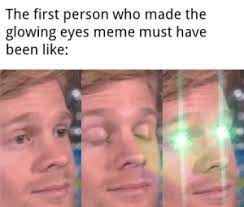

In [106]:
uplift_data = base.groupby(['user','part']).sum().reset_index(1).rename(columns={'part':'is_ab_test'})

In [107]:
uplift_data['is_ab_test'] = uplift_data['is_ab_test'] == 'AB'
uplift_data['target'] = uplift_data['click'] / uplift_data['view']
uplift_data.drop('click',axis=1,inplace=True)

In [108]:
uplift_aa = uplift_data.query('is_ab_test==0').drop('is_ab_test',axis=1)
uplift_ab = uplift_data.query('is_ab_test==1').drop('is_ab_test',axis=1)

In [109]:
def ci_check_meta_learners(meta_func,df,T,Y,**kwargs):
    ates = [meta_func(df.sample(frac=1, replace=True),T,Y,**kwargs).mean() for _ in tqdm(range(333))]

    model_stats = sps.norm(loc = np.mean(ates),scale=np.std(ates))

    return {'ttest': min(model_stats.cdf(0),model_stats.sf(0)),
            'mwtest': None,
            'uplift': model_stats.mean(),
            'relative_uplift':None,
            'ci_left': model_stats.ppf(0.025),
            'ci_right': model_stats.ppf(0.975),
            'ci_lenght': model_stats.ppf(0.975) - model_stats.ppf(0.025),
            }

In [110]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression
from tqdm.notebook import tqdm

In [111]:
def s_learner(df,Y,T,model=LGBMRegressor()):
    
    data = df.drop(Y,axis=1)
    target = df[Y]
    model.fit(data,target)

    return model.predict(data.assign(**{T:1})) - model.predict(data.assign(**{T:0}))


In [112]:
meta_learners_ci = {}

In [113]:
meta_learners_ci.update({'s_learner':ci_check_meta_learners(s_learner,uplift_ab,'target','ab')})

  0%|          | 0/333 [00:00<?, ?it/s]

In [114]:
meta_learners_result = {}

In [115]:
meta_learners_result['s_learner'] = {
                                    'AA':s_learner(uplift_aa,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                    'AB':s_learner(uplift_ab,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                        }

In [116]:
from copy import copy

In [117]:
def t_learner(df,Y,T,model=LGBMRegressor()):
    X0 = df.query(f'{T}==0').drop([Y,T],axis=1)
    Y0 = df.query(f'{T}==0')[Y]

    X1 = df.query(f'{T}==1').drop([Y,T],axis=1)
    Y1 = df.query(f'{T}==1')[Y]

    m0 = copy(model)
    m1 = copy(model)

    m0.fit(X0,Y0)
    m1.fit(X1,Y1)

    return m1.predict(df.drop([Y,T],axis=1)) - m0.predict(df.drop([Y,T],axis=1))


In [118]:
meta_learners_ci.update({'t_learner':ci_check_meta_learners(t_learner,uplift_ab,'target','ab')})

  0%|          | 0/333 [00:00<?, ?it/s]

In [119]:
meta_learners_result['t_learner'] = {
                                    'AA':t_learner(uplift_aa,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                    'AB':t_learner(uplift_ab,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                        }

In [120]:
from sklearn.model_selection import cross_val_predict

In [121]:
def dd_learner(df,Y,T,model=LGBMRegressor()):

    data = df.drop([Y,T],axis=1)
    target = df[Y]
    threatment = df[T]
    
    debaise = copy(model)
    denoise = copy(model)


    T_res = threatment - cross_val_predict(debaise,data,threatment,cv=5)
    Y_res = target - cross_val_predict(denoise,data,target,cv=5)

    W = T_res **2
    Y_star = Y_res / T_res

    final_model = copy(model)

    final_model.fit(data,Y_star,sample_weight=W)

    return final_model.predict(data).mean()


In [122]:
meta_learners_ci.update({'dd_learner':ci_check_meta_learners(dd_learner,uplift_ab,'target','ab')})

  0%|          | 0/333 [00:00<?, ?it/s]

In [123]:
# Для цисленных переменных влияния (сикдки , бонусы, баллы и тд)
meta_learners_result['dd_learner'] = {
                                    'AA':dd_learner(uplift_aa,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                    'AB':dd_learner(uplift_ab,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                        }

In [124]:
effect_size.update(meta_learners_result)

In [125]:
def dr_learner(df,Y,T):
    
    X = df.drop([T,Y],axis=1).columns

    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T].astype(bool)).predict_proba(df[X])[:, 1]

    mu0 = LGBMRegressor().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LGBMRegressor().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        (df[T]*(df[Y] - mu1)/ps + mu1) -
        ((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [126]:
meta_learners_ci.update({'dr_learner':ci_check_meta_learners(dr_learner,uplift_ab,'target','ab')})

  0%|          | 0/333 [00:00<?, ?it/s]

In [127]:
pd.DataFrame(meta_learners_ci)

,s_learner,t_learner,dd_learner,dr_learner
ttest,0.228533,0.425485,0.398684,0.409291
mwtest,NaN,NaN,NaN,NaN
uplift,0.000510,0.000242,0.000322,0.000286
relative_uplift,NaN,NaN,NaN,NaN
ci_left,-0.000833,-0.002284,-0.002135,-0.002161
ci_right,0.001852,0.002768,0.002779,0.002734
ci_lenght,0.002686,0.005052,0.004915,0.004895


# IPV & Double robust
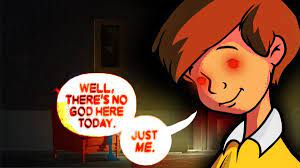

In [128]:
drdd_data = base.groupby(['user','part']).sum().reset_index(1).rename(columns={'part':'is_ab_test'})

In [129]:
drdd_data['is_ab_test'] = drdd_data['is_ab_test'] == 'AB'
drdd_data['target'] = drdd_data['click'] / drdd_data['view']
drdd_data.drop('click',axis=1,inplace=True)

## IPV

In [130]:
def IPV(df, T, y):
    X = df.drop([T,y],axis=1).columns
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

In [131]:
IPV(drdd_data.query('is_ab_test==True'),'ab','target')

0.00047964611313367503

In [132]:
ols_data = drdd_data.query('is_ab_test==True').astype(int)

In [133]:
ps_ols = sm.OLS(ols_data['target'].values,ols_data[['ab']].assign(const=1,ps=IPV(ols_data,'ab','target'))).fit()
raw_ols = sm.OLS(ols_data['target'].values,ols_data.drop(['is_ab_test','target'],axis=1).assign(const=1)).fit()

ab
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ps, dtype: object

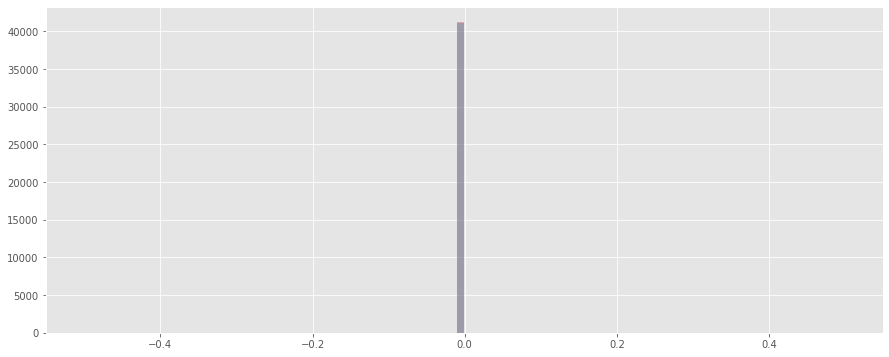

In [134]:
ols_data.assign(ps=IPV(ols_data,'ab','target')).groupby('ab')['ps'].hist(alpha=0.4,bins=100)

In [135]:
print(raw_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     164.1
Date:                Sat, 30 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:09:05   Log-Likelihood:                 36333.
No. Observations:               82308   AIC:                        -7.264e+04
Df Residuals:                   82294   BIC:                        -7.251e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
ab                        -0

In [136]:
print(ps_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.07351
Date:                Sat, 30 Jul 2022   Prob (F-statistic):              0.786
Time:                        18:09:05   Log-Likelihood:                 35280.
No. Observations:               82308   AIC:                        -7.056e+04
Df Residuals:                   82306   BIC:                        -7.054e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ab            -0.0003      0.001     -0.271      0.7

## DID

In [137]:
idx = drdd_data.groupby(level=0)['is_ab_test'].nunique().where(lambda x: x==2).dropna().index
drdd_data = drdd_data.loc[idx]

In [138]:
def DRDID ( df,X,W,T,Y):

    ps = LogisticRegression(penalty='none').fit(df.query(f'{W}==0')[X],df.query(f'{W}==0')[T]).predict_proba(df.query(f'{W}==0')[X])[:,1]
    wp_tr = df.query(f'{W}==0')[T] / df.query(f'{W}==0')[T].mean()
    wp_count = ps * (1 - df.query(f'{W}==0')[T]) / (1 - ps)
    wp_pr = wp_count / wp_count.mean()
    ipv = wp_tr - wp_pr

    mu_0_p = LinearRegression().fit(df.query(f'{T}==0 & {W}==1')[X], df.query(f'{T}==0 & {W}==0')[Y]).predict(df.query(f'{W}==1')[X])

    mu_1_p = LinearRegression().fit(df.query(f'{T}==0 & {W}==1')[X], df.query(f'{T}==0 & {W}==1')[Y]).predict(df.query(f'{W}==1')[X])



    mu_delta = mu_1_p - mu_0_p

    Y_delta = df.query(f'{W}==1')[Y] - df.query(f' {W}==0')[Y]


    ATT = np.mean(ipv * (Y_delta - mu_delta))

    return ATT

In [139]:
did_result = DRDID(drdd_data, X=drdd_data.filter(regex='cov').columns,W='is_ab_test',T='ab',Y='target')

In [140]:
effect_size['did'] = {'AB':did_result}

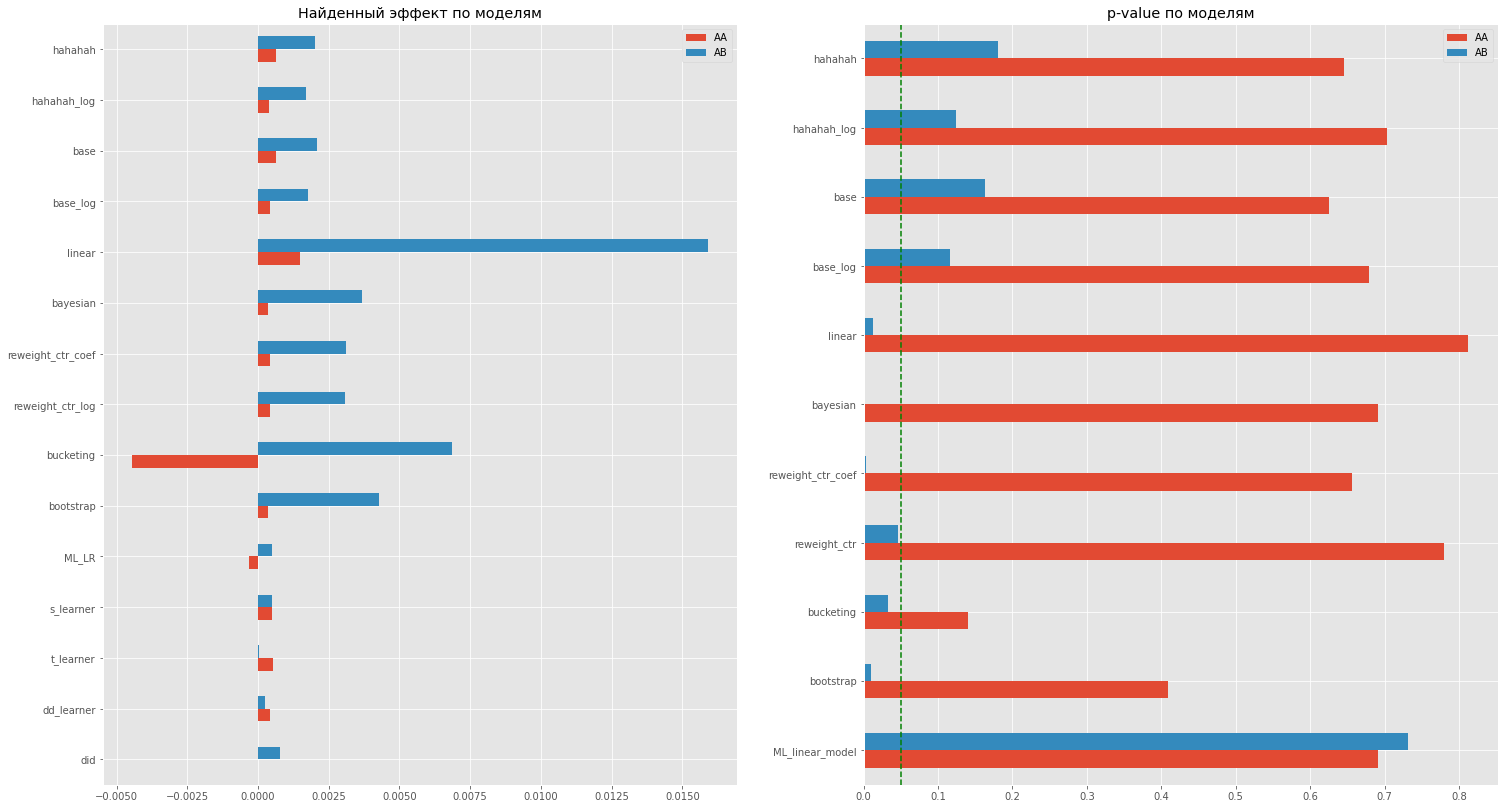

In [141]:
fig,ax = plt.subplots(1,2,figsize=(25,14))
pd.DataFrame(effect_size).T.iloc[::-1].plot.barh(title='Найденный эффект по моделям',ax=ax[0])
pd.DataFrame(test_of_tests).T.iloc[::-1].plot.barh(title='p-value по моделям',ax=ax[1])
ax[1].axvline(0.05,linestyle='--',color='g')

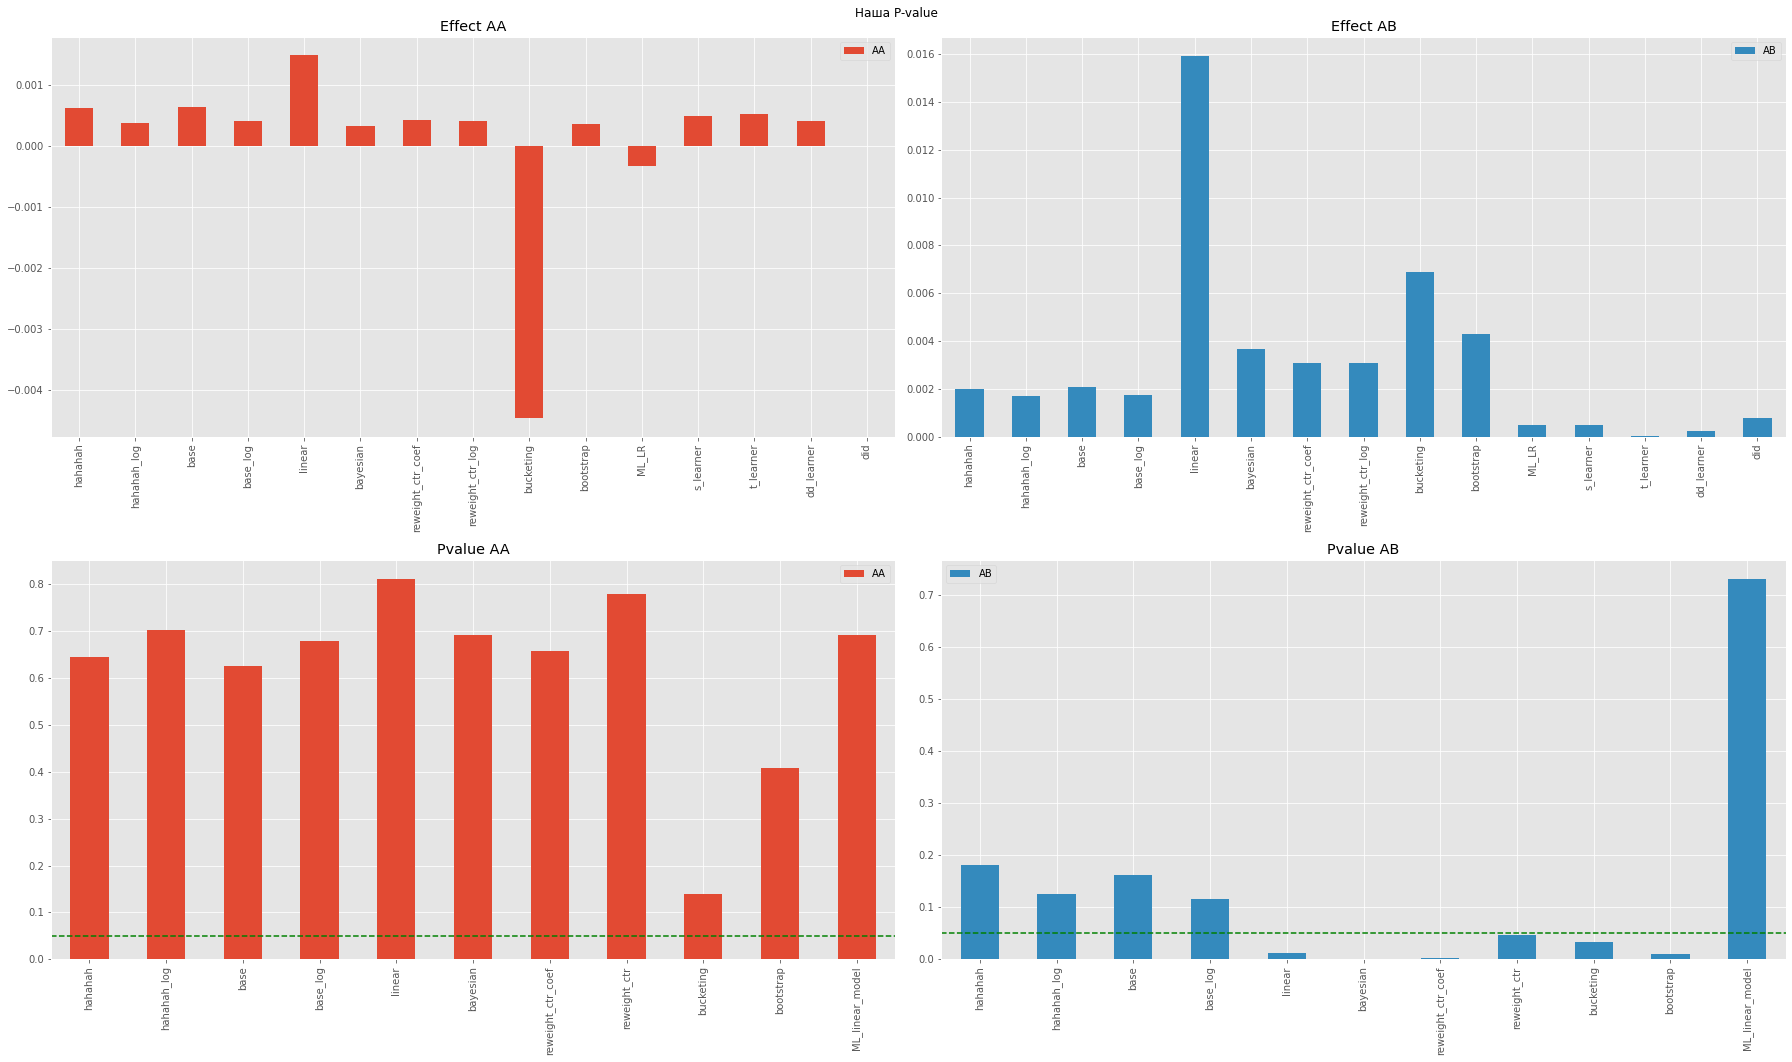

In [142]:
fig,ax = plt.subplots(2,2,figsize=(25,15))
pd.DataFrame(effect_size).T.plot.bar(subplots=True,title='Найденный эффект по моделям',ax=ax[0])
pd.DataFrame(test_of_tests).T.plot.bar(subplots=True,title='Наша P-value',ax=ax[1])
ax[1,1].axhline(0.05,linestyle='--',color='g')
ax[1,0].axhline(0.05,linestyle='--',color='g')
ax[0,0].set_title('Effect AA')
ax[0,1].set_title('Effect AB')
ax[1,0].set_title('Pvalue AA')
ax[1,1].set_title('Pvalue AB')
plt.tight_layout()

# Ссылочки

Общее  
[Авито общая инфа о инфраструктуре](https://habr.com/ru/company/avito/blog/454164/)
[Большой гайд по оптимизации от VK](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f)  
[ AB лайфхаки авито  Часть 1 ( тестирование критериев )](https://habr.com/ru/company/avito/blog/571094/)  
[Антипаттерны АБ](https://www.evanmiller.org/how-not-to-run-an-ab-test.html)  

CUPED   
[ AB лайфхаки авито  Часть 2 ( сниженеие дисперсии и джедайские техники )](https://habr.com/ru/company/avito/blog/571096/)  
[ AB лайфхаки авито  Часть 3 ( ML техники и апдейт CUPED )](https://habr.com/ru/company/avito/blog/590105/)  
[CUPED + Стратификация от yandex](https://habr.com/ru/company/yandex/blog/497804/)  

Bayes  

[Пример баесовского АБ (простой)](https://academy.yandex.ru/posts/prostoy-gid-po-bayesovskomu-a-b-testirovaniyu-na-python)  
[Bayies чуть сложнее на примерах](https://medium.com/convoy-tech/the-power-of-bayesian-a-b-testing-f859d2219d5)  
[Более сложная инфа о баесе](https://www.evanmiller.org/bayesian-ab-testing.html)  
[Бандиты и баес на русском (ч1)](https://craftappmobile.com/bayesian-ab-testing-part-1/)  
[Бандиты и баес на русском (ч2)](https://craftappmobile.com/bayesian-ab-testing-part-2/)  


Matching & Causal

[Крутая гит книжка про каузальность](https://matheusfacure.github.io/python-causality-handbook/10-Matching.html)  
[Матчинг для АБ](https://humboldt-wi.github.io/blog/research/applied_predictive_modeling_19/matching_methods/)  
[Книга по каузальности от биопрофессора (осторожно, это жестко)](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/2021/03/ciwhatif_hernanrobins_30mar21.pdf)  
[Каузальные метода на русском доступно без регистрации и смс](https://koch-kir.medium.com/causal-inference-from-observational-data-%D0%B8%D0%BB%D0%B8-%D0%BA%D0%B0%D0%BA-%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%81%D1%82%D0%B8-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82-%D0%B1%D0%B5%D0%B7-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82%D0%B0-afb84f2579f2)  


[AB как модели](https://lindeloev.github.io/tests-as-linear/)

DRDID :  

[Double Robust & inverse scaling](https://drive.google.com/file/d/1vgwNdBbrSwCaHF7EnJh06Ukpu1mSzIxO/view)